# Notebook 01: Core Modelling

## Cell 1 — Purpose + Research Question + Objective

## Business Research Question (RQ)
How can predictive modelling of lead characteristics and agent performance variation be used to design an evidence-based system for optimising agent–lead allocation across HD’s campaigns?

## Research Objective 
To develop a lead-level conversion model incorporating lead, campaign, and agent information, and to assess how model outputs could inform agent–lead allocation decisions across HD’s campaigns.

This objective is addressed in two analytical stages:
1. **Conversion modelling:** Build and evaluate a predictive model to estimate the probability that a lead converts into a sale.
2. **Allocation implications:** Interpret model outputs to examine agent performance variation and discuss how predicted probabilities could support lead allocation decisions.

## Unit of analysis
- **Lead-level** (one row per lead).
- Outcome variable: **sale_flag** (1 = lead matched to a sale record, 0 = otherwise).

## Datasets used
- **Primary (core modelling):** *HD Leads and Sales last 12 months* (Leads, Sales, Agents, List IDs tabs).
- **Optional (diagnostics only):** *sales_unmatched_after_join* (used only to quantify unmatched sales as a limitation).
- **Excluded:** *Health_Deal_Lead_Report_created* (not required for the scoped objective).

## Cell 2 — Imports + config

In [5]:
# This cell sets up all libraries and global settings used throughout the notebook

import io                     # Used to handle in-memory byte streams (for decrypted Excel file)
import numpy as np            # Numerical operations and arrays
import pandas as pd           # Data manipulation and DataFrames
import msoffcrypto            # Decrypts password-protected Excel files

# ---- File configuration ----
# Path to the password-protected Excel file
FILE_PATH = "HD Leads and Sales last 12 months.xlsx"

# Password required to open the Excel file
PASSWORD = "K33pS@fePlease123"

# ---- Pandas display settings (for readability only) ----
pd.set_option("display.max_columns", 200)   # Show all columns when printing DataFrames
pd.set_option("display.width", 140)         # Prevent line wrapping in DataFrame output

## Cell 3 — Decrypt the password-protected workbook and load the sheets

In [7]:
# This cell reads the Excel file securely in-memory (no decrypted file written to disk),
# then loads the four sheets into pandas DataFrames.

# Open the encrypted Excel file in binary mode (required for decryption)
with open(FILE_PATH, "rb") as f:
    office_file = msoffcrypto.OfficeFile(f)          # Create an OfficeFile object from the encrypted workbook
    office_file.load_key(password=PASSWORD)          # Provide the password so the file can be decrypted
    decrypted = io.BytesIO()                         # Create an in-memory buffer for the decrypted content
    office_file.decrypt(decrypted)                   # Decrypt the workbook into the in-memory buffer

# Reset the buffer pointer to the beginning so pandas can read it
decrypted.seek(0)

# Create an ExcelFile object so we can read multiple sheets efficiently
xls = pd.ExcelFile(decrypted, engine="openpyxl")

# Load each sheet by its exact name into a DataFrame
leads_raw  = pd.read_excel(xls, sheet_name="Leads")     # All lead records (base population)
sales_raw  = pd.read_excel(xls, sheet_name="Sales")     # Sales outcomes (subset of leads that converted)
agents_raw = pd.read_excel(xls, sheet_name="Agents")    # Agent reference table (names + VICIDIAL_ID)
lists_raw  = pd.read_excel(xls, sheet_name="List IDs")  # Campaign/list reference table (IDs + names)

# Print quick checks to confirm everything loaded correctly
print("Sheets detected:", xls.sheet_names)              # Confirms sheet names in the workbook
print("Shapes (raw):",                                 # Confirms row/column counts for each sheet
      leads_raw.shape, sales_raw.shape, agents_raw.shape, lists_raw.shape)

Sheets detected: ['Leads', 'Sales', 'Agents', 'List IDs']
Shapes (raw): (159375, 23) (6928, 24) (41, 3) (51, 9)


## Cell 4 - Standardise column names

In [9]:
# This converts column names into consistent snake_case so we can reference them reliably in code.

def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardise columns to snake_case:
    - strip leading/trailing spaces
    - replace internal whitespace with underscores
    - remove non-alphanumeric characters (except underscores)
    - convert to lowercase
    """
    out = df.copy()  # Work on a copy so the original raw DataFrame remains available if needed
    out.columns = (
        out.columns.astype(str)                         # Ensure all column labels are strings
        .str.strip()                                    # Remove leading/trailing whitespace
        .str.replace(r"\s+", "_", regex=True)           # Replace one/more spaces with underscore
        .str.replace(r"[^0-9a-zA-Z_]+", "", regex=True) # Remove special characters
        .str.lower()                                    # Convert to lowercase
    )
    return out

# Create cleaned versions of each sheet (recommended for all downstream analysis)
leads  = clean_cols(leads_raw)    # Leads table (base population)
sales  = clean_cols(sales_raw)    # Sales table (conversion outcomes)
agents = clean_cols(agents_raw)   # Agent reference table
lists  = clean_cols(lists_raw)    # Campaign/list reference table

# Quick check: print key column names to confirm standardisation worked
print("Leads columns (cleaned):", list(leads.columns))
print("Sales columns (cleaned):", list(sales.columns))

Leads columns (cleaned): ['lead_id', 'entry_date', 'status', 'user', 'vendor_lead_code', 'source_id', 'list_id', 'gmt_offset_now', 'called_since_last_reset', 'phone_code', 'phone_number', 'title', 'state', 'lead_source', 'type', 'country_code', 'email', 'security_phrase', 'called_count', 'last_local_call_time', 'rank', 'owner', 'entry_list_id']
Sales columns (cleaned): ['age', 'email_id', 'contact_home_ph', 'contact_mobile_ph', 'primary_gender', 'customer_type', 'current_health_fund', 'state_s', 'cover_start_date', 'policy_type', 'hospital_band', 'extras_band', 'phone_agent', 'sale_date', 'health_fund_sold', 'payment_frequency', 'payment_method', 'lead_source', 'payment_date', 'yearly_savings', 'sale_date__time', 'yearly_premium', 'phone_agent_status', 'sale_total']


## Cell 5 — Data Validation & Consistency Checks

In [11]:
# This ensures date fields are usable for time-based matching and analysis.

# Convert Leads date/time columns to datetime (invalid parsing becomes NaT)
leads["entry_date"] = pd.to_datetime(leads["entry_date"], errors="coerce")                 # Lead creation timestamp
leads["last_local_call_time"] = pd.to_datetime(leads["last_local_call_time"], errors="coerce")  # Last call timestamp

# Convert Sales date/time columns to datetime (invalid parsing becomes NaT)
sales["sale_date"] = pd.to_datetime(sales["sale_date"], errors="coerce")                  # Sale date
sales["payment_date"] = pd.to_datetime(sales["payment_date"], errors="coerce")            # Payment date (if present)
sales["sale_date__time"] = pd.to_datetime(sales["sale_date__time"], errors="coerce")      # Sale timestamp (if present)

# Print date ranges to confirm dataset coverage and overlap
print("Leads entry_date range:", leads["entry_date"].min(), "→", leads["entry_date"].max())
print("Sales sale_date range:", sales["sale_date"].min(), "→", sales["sale_date"].max())

# Check missingness in key identifiers required for matching and modelling
key_cols_leads = ["lead_id", "entry_date", "phone_number", "email", "list_id", "lead_source", "user"]
key_cols_sales = ["sale_date", "contact_mobile_ph", "contact_home_ph", "email_id", "phone_agent"]

print("\nMissingness (Leads):")
print(leads[key_cols_leads].isna().mean().sort_values(ascending=False).map(lambda x: f"{x:.2%}"))

print("\nMissingness (Sales):")
print(sales[key_cols_sales].isna().mean().sort_values(ascending=False).map(lambda x: f"{x:.2%}"))

# Confirm basic row counts (should match your raw shapes)
print("\nRow counts:")
print("Leads:", len(leads), "| Sales:", len(sales))

Leads entry_date range: 2024-10-02 11:25:00 → 2025-10-02 11:06:00
Sales sale_date range: 2024-10-01 00:00:00 → 2025-09-30 00:00:00

Missingness (Leads):
email           26.55%
user             0.34%
phone_number     0.12%
lead_source      0.12%
lead_id          0.00%
entry_date       0.00%
list_id          0.00%
dtype: object

Missingness (Sales):
contact_home_ph      95.80%
contact_mobile_ph     1.65%
sale_date             0.00%
email_id              0.00%
phone_agent           0.00%
dtype: object

Row counts:
Leads: 159375 | Sales: 6928


## Cell 6 — Create matching keys

In [13]:
# Purpose:
# - Standardise phone numbers and emails so Sales records can be matched to Leads reliably.
# - Australian phone numbers only (no country-code stripping required).

def normalise_phone(x):
    """
    Convert a phone value to a comparable key:
    - keep digits only
    - remove leading zeros (formatting differences across systems)
    Returns NaN if the input is missing or empty after cleaning.
    """
    if pd.isna(x):                                   # Missing value remains missing
        return np.nan
    s = "".join(ch for ch in str(x) if ch.isdigit()) # Keep digits only
    if s == "":                                      # Empty after cleaning
        return np.nan

    # Remove leading zeros caused by formatting/export differences
    while len(s) > 0 and s[0] == "0":
        s = s[1:]

    return s if s != "" else np.nan

def normalise_email(x):
    """
    Convert an email value to a comparable key:
    - lower-case
    - strip surrounding whitespace
    Returns NaN if missing or blank.
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    return s if s != "" else np.nan

# --- Leads keys ---
# Primary identifier for matching
leads["phone_key"] = leads["phone_number"].map(normalise_phone)

# Secondary identifier for matching
leads["email_key"] = leads["email"].map(normalise_email)

# --- Sales keys ---
# Mobile phone is preferred; home phone is used as a fallback
sales["phone_key_mobile"] = sales["contact_mobile_ph"].map(normalise_phone)
sales["phone_key_home"]   = sales["contact_home_ph"].map(normalise_phone)
sales["phone_key"]        = sales["phone_key_mobile"].fillna(sales["phone_key_home"])

# Email identifier
sales["email_key"] = sales["email_id"].map(normalise_email)

# --- Key quality checks (used later for diagnostics and limitations) ---
print("Null rates (matching keys):")
print("  Leads.phone_key:", f"{leads['phone_key'].isna().mean():.2%}")
print("  Sales.phone_key:", f"{sales['phone_key'].isna().mean():.2%}")
print("  Leads.email_key:", f"{leads['email_key'].isna().mean():.2%}")
print("  Sales.email_key:", f"{sales['email_key'].isna().mean():.2%}")

# Check whether Sales identifiers generally exist in Leads
lead_phone_set  = set(leads["phone_key"].dropna().unique())
sales_phone_set = set(sales["phone_key"].dropna().unique())
lead_email_set  = set(leads["email_key"].dropna().unique())
sales_email_set = set(sales["email_key"].dropna().unique())

print("\nKey overlap (unique values):")
print(f"  Sales phones present in Leads: {len(sales_phone_set & lead_phone_set)}/{len(sales_phone_set)} "
      f"({len(sales_phone_set & lead_phone_set)/max(1,len(sales_phone_set)):.1%})")
print(f"  Sales emails present in Leads: {len(sales_email_set & lead_email_set)}/{len(sales_email_set)} "
      f"({len(sales_email_set & lead_email_set)/max(1,len(sales_email_set)):.1%})")


Null rates (matching keys):
  Leads.phone_key: 0.12%
  Sales.phone_key: 0.00%
  Leads.email_key: 26.55%
  Sales.email_key: 0.00%

Key overlap (unique values):
  Sales phones present in Leads: 6221/6530 (95.3%)
  Sales emails present in Leads: 5965/6535 (91.3%)


## Cell 7 — Deterministic Sales → Lead matching (one row per sale)

In [15]:
# Purpose:
# - Match each sale to at most ONE lead.
# - Enforce logical timing (lead created before sale).
# - Use a clear, reproducible rule 

# Create a stable unique identifier for each sale row
sales = sales.copy()
sales["_sale_row_id"] = np.arange(len(sales))   # One ID per original sales row

# Keep only the columns needed for matching and timing
sales_match_cols = [
    "_sale_row_id", "sale_date", "phone_key", "email_key", "phone_agent"
]
leads_match_cols = [
    "lead_id", "entry_date", "phone_key", "email_key", "user", "list_id"
]

sales_m = sales[sales_match_cols].copy()
leads_m = leads[leads_match_cols].copy()

# -----------------------------
# Step 1: PHONE-based matching
# -----------------------------
# Join sales to leads on phone_key (many-to-many possible at this stage)
phone_join = sales_m.merge(
    leads_m,
    how="left",
    on="phone_key",
    suffixes=("_sale", "_lead")
)

# Keep only logically valid matches: lead must exist and be created on/before the sale
phone_join = phone_join[
    phone_join["lead_id"].notna() &
    phone_join["entry_date"].notna() &
    phone_join["sale_date"].notna() &
    (phone_join["entry_date"] <= phone_join["sale_date"])
]

# For each sale, select the lead with entry_date closest to the sale_date (but before it)
phone_best = (
    phone_join
    .assign(time_gap=lambda d: (d["sale_date"] - d["entry_date"]).dt.total_seconds())
    .sort_values(["_sale_row_id", "time_gap"])
    .groupby("_sale_row_id", as_index=False)
    .first()
)

# -----------------------------
# Step 2: EMAIL-based matching (only for unmatched sales)
# -----------------------------
matched_sale_ids = set(phone_best["_sale_row_id"])

email_candidates = sales_m[~sales_m["_sale_row_id"].isin(matched_sale_ids)]

email_join = email_candidates.merge(
    leads_m,
    how="left",
    on="email_key",
    suffixes=("_sale", "_lead")
)

email_join = email_join[
    email_join["lead_id"].notna() &
    email_join["entry_date"].notna() &
    email_join["sale_date"].notna() &
    (email_join["entry_date"] <= email_join["sale_date"])
]

email_best = (
    email_join
    .assign(time_gap=lambda d: (d["sale_date"] - d["entry_date"]).dt.total_seconds())
    .sort_values(["_sale_row_id", "time_gap"])
    .groupby("_sale_row_id", as_index=False)
    .first()
)

# -----------------------------
# Step 3: Combine PHONE + EMAIL matches
# -----------------------------
sales_lead_matched = pd.concat([phone_best, email_best], ignore_index=True)

# Sanity checks
total_sales = len(sales)
matched_sales = len(sales_lead_matched)
unmatched_sales = total_sales - matched_sales

print("Sales → Lead matching results:")
print(f"  Total sales: {total_sales}")
print(f"  Matched sales: {matched_sales} ({matched_sales / total_sales:.1%})")
print(f"  Unmatched sales: {unmatched_sales} ({unmatched_sales / total_sales:.1%})")

# Keep only the essential columns for downstream use
sales_lead_matched = sales_lead_matched[
    ["_sale_row_id", "lead_id", "sale_date", "phone_agent", "user", "list_id"]
]

# Save for diagnostics / appendix
sales_lead_matched.to_csv("sales_lead_matched_one_to_one.csv", index=False)


Sales → Lead matching results:
  Total sales: 6928
  Matched sales: 4246 (61.3%)
  Unmatched sales: 2682 (38.7%)


## Cell 8 — Build the lead-level modelling table and create sale_flag

In [17]:
# Purpose:
# - Create one row per lead (unit of analysis).
# - Label each lead with sale_flag = 1 if it matched a sale, else 0.

# Start from the full Leads table (one row per lead)
lead_model = leads.copy()

# Identify leads that matched at least one sale (from Cell 7 result)
matched_lead_ids = set(sales_lead_matched["lead_id"].dropna().unique())

# Create binary outcome variable
lead_model["sale_flag"] = lead_model["lead_id"].isin(matched_lead_ids).astype(int)

# Attach sale_date to matched leads only (kept sparse by design)
lead_model = lead_model.merge(
    sales_lead_matched[["lead_id", "sale_date"]],
    how="left",
    on="lead_id"
)

# Quick checks
print("Lead-level table shape:", lead_model.shape)
print("Conversion rate:", f"{lead_model['sale_flag'].mean():.2%}")
print("sale_flag counts:")
print(lead_model["sale_flag"].value_counts())

Lead-level table shape: (159550, 27)
Conversion rate: 2.66%
sale_flag counts:
sale_flag
0    155304
1      4246
Name: count, dtype: int64


## Cell 9 — EDA for modelling

In [19]:
# Purpose:
# - Confirm class imbalance
# - Sanity-check conversion rates across a few key dimensions
# - Ensure features are usable before modelling

# Overall class balance (already seen, repeated here for context)
print("Overall conversion rate:", f"{lead_model['sale_flag'].mean():.2%}")
print("Class counts:")
print(lead_model["sale_flag"].value_counts())

# Conversion rate by campaign (list_id) — top 10 by volume
conv_by_list = (
    lead_model
    .groupby("list_id", dropna=False)
    .agg(
        leads=("lead_id", "count"),
        conversion_rate=("sale_flag", "mean")
    )
    .sort_values("leads", ascending=False)
    .head(10)
)

print("\nTop 10 campaigns by lead volume (conversion rates):")
print(conv_by_list)

# Conversion rate by lead source — top 10 by volume
conv_by_source = (
    lead_model
    .groupby("lead_source", dropna=False)
    .agg(
        leads=("lead_id", "count"),
        conversion_rate=("sale_flag", "mean")
    )
    .sort_values("leads", ascending=False)
    .head(10)
)

print("\nTop 10 lead sources by volume (conversion rates):")
print(conv_by_source)

# Conversion rate by agent (user) — only agents with sufficient volume
conv_by_agent = (
    lead_model
    .groupby("user", dropna=False)
    .agg(
        leads=("lead_id", "count"),
        conversion_rate=("sale_flag", "mean")
    )
    .query("leads >= 200")   # threshold to avoid noisy rates
    .sort_values("conversion_rate", ascending=False)
    .head(10)
)

print("\nTop agents by conversion rate (min 200 leads):")
print(conv_by_agent)

# Missingness check for candidate modelling features
candidate_features = [
    "list_id", "lead_source", "type", "state", "called_count",
    "called_since_last_reset", "rank", "user"
]

print("\nMissingness in candidate modelling features:")
print(
    lead_model[candidate_features]
    .isna()
    .mean()
    .sort_values(ascending=False)
    .map(lambda x: f"{x:.2%}")
)


Overall conversion rate: 2.66%
Class counts:
sale_flag
0    155304
1      4246
Name: count, dtype: int64

Top 10 campaigns by lead volume (conversion rates):
         leads  conversion_rate
list_id                        
40155    93511         0.037782
47116    10050         0.000299
37080     6410         0.015757
40980     5311         0.001883
40982     5251         0.002857
40981     5248         0.002477
40983     5247         0.001334
40985     5117         0.033418
40118     2353         0.008075
39420     2003         0.005991

Top 10 lead sources by volume (conversion rates):
                        leads  conversion_rate
lead_source                                   
oursmartquotes.com.au   88016         0.037539
Tedirex                 31869         0.002855
Google Adwords          15084         0.029833
Data4U October          10050         0.000299
organic                  4093         0.021256
Right Health Insurance   3303         0.025431
Energy Deal Sales        1904  

## Cell 10 — Feature selection and encoding for modelling

In [21]:
# Purpose:
# - Select a small, defensible feature set
# - Encode categorical variables for logistic regression
# - Prepare X (features) and y (outcome)

# Select features to include in the model
model_features = [
    "list_id",
    "lead_source",
    "type",
    "state",
    "called_count",
    "called_since_last_reset",
    "rank",
    "user"   # agent ID (treated as categorical)
]

# Subset the modelling table
model_df = lead_model[model_features + ["sale_flag"]].copy()

# Handle missing categorical values by assigning an explicit category
for col in ["list_id", "lead_source", "type", "state", "user"]:
    model_df[col] = model_df[col].fillna("Unknown").astype(str)

# Handle missing numeric values (minimal, conservative)
model_df["called_count"] = model_df["called_count"].fillna(0)
model_df["called_since_last_reset"] = model_df["called_since_last_reset"].fillna(0)
model_df["rank"] = model_df["rank"].fillna(0)

# One-hot encode categorical variables
X = pd.get_dummies(
    model_df.drop(columns=["sale_flag"]),
    drop_first=True
)

# Outcome variable
y = model_df["sale_flag"]

# Final sanity check
print("Feature matrix shape:", X.shape)
print("Outcome distribution:")
print(y.value_counts())


Feature matrix shape: (159550, 185)
Outcome distribution:
sale_flag
0    155304
1      4246
Name: count, dtype: int64


## Cell 11 — Logistic regression modelling

In [23]:
# Purpose:
# - Fit a baseline logistic regression model
# - Evaluate predictive performance on held-out data

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Train / test split (stratified to preserve class imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# Initialise logistic regression
# - class_weight='balanced' accounts for severe class imbalance
# - max_iter increased to ensure convergence
logit = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    n_jobs=-1
)

# Fit model
logit.fit(X_train, y_train)

# Predict probabilities on test set
y_prob = logit.predict_proba(X_test)[:, 1]

# Evaluate using ROC-AUC (appropriate for imbalanced classification)
auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", round(auc, 3))

# Threshold-based classification summary at a 0.5 cut-off (reported for interpretability)
y_pred = (y_prob >= 0.5).astype(int)
print("\nClassification report (threshold = 0.5):")
print(classification_report(y_test, y_pred))

ROC-AUC: 0.76

Classification report (threshold = 0.5):
              precision    recall  f1-score   support

           0       0.99      0.61      0.76     38826
           1       0.05      0.82      0.10      1062

    accuracy                           0.62     39888
   macro avg       0.52      0.72      0.43     39888
weighted avg       0.97      0.62      0.74     39888



## Cell 12 — Interpretation: key predictors and agent effects

In [25]:
# Purpose:
# - Identify influential predictors from the logistic model
# - Summarise agent-level effects to inform allocation decisions

# Get model coefficients
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": logit.coef_[0]
})

# Rank by absolute effect size
coef_df["abs_coeff"] = coef_df["coefficient"].abs()
top_coeffs = coef_df.sort_values("abs_coeff", ascending=False).head(15)

print("Top predictors by absolute coefficient:")
print(top_coeffs[["feature", "coefficient"]])

# --- Agent effects (interpretable summary) ---
# Extract agent-related coefficients (features starting with 'user_')
agent_coefs = coef_df[coef_df["feature"].str.startswith("user_")].copy()
agent_coefs["agent_id"] = agent_coefs["feature"].str.replace("user_", "", regex=False)

# Rank agents by coefficient (higher = higher predicted conversion likelihood)
top_agents = agent_coefs.sort_values("coefficient", ascending=False).head(10)
bottom_agents = agent_coefs.sort_values("coefficient", ascending=True).head(10)

print("\nTop agents by model coefficient:")
print(top_agents[["agent_id", "coefficient"]])

print("\nBottom agents by model coefficient:")
print(bottom_agents[["agent_id", "coefficient"]])

# --- Allocation implication (simple illustration) ---
print("\nAllocation implication:")
print(
    "Predicted conversion probabilities vary systematically by agent, "
    "suggesting that lead assignment informed by model outputs could "
    "improve conversion efficiency relative to uniform allocation."
)


Top predictors by absolute coefficient:
                          feature  coefficient
178                  user_14195.0    -4.265149
143                  user_12695.0     2.211158
52    lead_source_CHOOSE N SWITCH     2.193313
144                  user_12730.0     2.111055
117                      state_ql     2.104204
182                  user_14199.0    -2.089325
53     lead_source_Data4U October    -1.680751
27                  list_id_47116    -1.680751
76            lead_source_Tedirex    -1.671893
12                  list_id_40971    -1.650278
127     called_since_last_reset_Y    -1.537942
26                  list_id_47111     1.525644
110                      state_Vi     1.437196
165                  user_14018.0    -1.424910
72   lead_source_SEO_HOMEPAGE_NEW     1.415688

Top agents by model coefficient:
    agent_id  coefficient
143  12695.0     2.211158
144  12730.0     2.111055
158  13677.0     1.011746
138  11264.0     0.939969
161  13843.0     0.919895
140  11741.0     0

# Cell 13 — Conditional suitability: Agent × Lead Source interactions

In [27]:
# Purpose:
# - Test whether agent effects vary by lead source (agent–source fit)
# - Produce a simple routing table (top agents per lead source)

# --- 1) Filter to reduce sparsity and keep results stable ---
# Keep only agents with sufficient lead volume
agent_counts = lead_model["user"].value_counts(dropna=True)
keep_agents = set(agent_counts[agent_counts >= 200].index.astype(str))

# Keep only top lead sources by volume
top_sources = set(lead_model["lead_source"].value_counts(dropna=True).head(10).index.astype(str))

# Build a compact dataframe
df_int = lead_model[["sale_flag", "user", "lead_source"]].copy()
df_int["user"] = df_int["user"].fillna("Unknown").astype(str)
df_int["lead_source"] = df_int["lead_source"].fillna("Unknown").astype(str)

df_int = df_int[df_int["user"].isin(keep_agents) & df_int["lead_source"].isin(top_sources)].copy()

print("Interaction dataset shape:", df_int.shape)
print("Conversion rate (interaction sample):", f"{df_int['sale_flag'].mean():.2%}")

# --- 2) Create main effects + interaction feature ---
df_int["agent_source"] = df_int["user"] + " | " + df_int["lead_source"]

X_int = pd.get_dummies(df_int[["user", "lead_source", "agent_source"]], drop_first=True)
y_int = df_int["sale_flag"]

# --- 3) Fit logistic regression with class balancing ---
Xtr, Xte, ytr, yte = train_test_split(
    X_int, y_int, test_size=0.25, random_state=42, stratify=y_int
)

logit_int = LogisticRegression(class_weight="balanced", max_iter=1000, n_jobs=-1)
logit_int.fit(Xtr, ytr)

yprob = logit_int.predict_proba(Xte)[:, 1]
auc_int = roc_auc_score(yte, yprob)
print("ROC-AUC (interaction model):", round(auc_int, 3))

# --- 4) Extract top agent–source combinations (interaction terms) ---
coef_int = pd.DataFrame({"feature": X_int.columns, "coefficient": logit_int.coef_[0]})
int_terms = coef_int[coef_int["feature"].str.startswith("agent_source_")].copy()
int_terms["agent_source"] = int_terms["feature"].str.replace("agent_source_", "", regex=False)

# Split back into agent and source
split = int_terms["agent_source"].str.split(" \\| ", expand=True)
int_terms["agent_id"] = split[0]
int_terms["lead_source"] = split[1]

# For each lead source, show top 5 agents by interaction coefficient
top_by_source = (
    int_terms.sort_values(["lead_source", "coefficient"], ascending=[True, False])
    .groupby("lead_source", as_index=False)
    .head(5)
    [["lead_source", "agent_id", "coefficient"]]
)

print("\nTop agent–source combinations (top 5 agents per source):")
print(top_by_source)

# Save routing-style output for report appendix / recommendation table
top_by_source.to_csv("routing_top_agents_by_source.csv", index=False)


Interaction dataset shape: (156714, 3)
Conversion rate (interaction sample): 2.67%
ROC-AUC (interaction model): 0.742

Top agent–source combinations (top 5 agents per source):
                lead_source agent_id  coefficient
149         CHOOSE N SWITCH  13416.0     2.302307
276         CHOOSE N SWITCH  14017.0     1.869856
167         CHOOSE N SWITCH  13505.0     1.568826
109         CHOOSE N SWITCH  13125.0     1.518110
119         CHOOSE N SWITCH  13216.0     1.424568
306          Data4U October  14021.0     1.915792
234          Data4U October  13828.0    -0.002270
250          Data4U October  13843.0    -0.005479
110          Data4U October  13125.0    -0.018062
120          Data4U October  13216.0    -0.018385
287       Energy Deal Sales  14018.0     3.986071
85        Energy Deal Sales  12413.0     2.299039
150       Energy Deal Sales  13416.0     2.148476
268       Energy Deal Sales  13987.0     1.623751
294       Energy Deal Sales  14019.0     1.526638
242          Google Adwo

## Cell 14 — Conditional suitability: Agent × State interactions

In [29]:
# Purpose:
# - Examine whether agent performance varies by customer state
# - Compare geographic suitability against lead-source effects

# --- 1) Filter to ensure stability ---
# Keep agents with sufficient volume
agent_counts = lead_model["user"].value_counts(dropna=True)
keep_agents = set(agent_counts[agent_counts >= 200].index.astype(str))

# Keep states with sufficient volume
top_states = set(lead_model["state"].value_counts(dropna=True).head(6).index)

df_state = lead_model[["sale_flag", "user", "state"]].copy()
df_state["user"] = df_state["user"].fillna("Unknown").astype(str)
df_state["state"] = df_state["state"].fillna("Unknown")

df_state = df_state[
    df_state["user"].isin(keep_agents) & df_state["state"].isin(top_states)
].copy()

print("State interaction dataset shape:", df_state.shape)
print("Conversion rate (state interaction sample):", f"{df_state['sale_flag'].mean():.2%}")

# --- 2) Create interaction feature ---
df_state["agent_state"] = df_state["user"] + " | " + df_state["state"]

X_state = pd.get_dummies(df_state[["user", "state", "agent_state"]], drop_first=True)
y_state = df_state["sale_flag"]

# --- 3) Fit interaction model ---
Xtr, Xte, ytr, yte = train_test_split(
    X_state, y_state, test_size=0.25, random_state=42, stratify=y_state
)

logit_state = LogisticRegression(class_weight="balanced", max_iter=1000, n_jobs=-1)
logit_state.fit(Xtr, ytr)

yprob = logit_state.predict_proba(Xte)[:, 1]
auc_state = roc_auc_score(yte, yprob)
print("ROC-AUC (agent × state model):", round(auc_state, 3))

# --- 4) Extract interaction effects ---
coef_state = pd.DataFrame({
    "feature": X_state.columns,
    "coefficient": logit_state.coef_[0]
})

int_state = coef_state[coef_state["feature"].str.startswith("agent_state_")].copy()
int_state["agent_state"] = int_state["feature"].str.replace("agent_state_", "", regex=False)

split = int_state["agent_state"].str.split(" \\| ", expand=True)
int_state["agent_id"] = split[0]
int_state["state"] = split[1]

# Top and bottom agents per state
top_by_state = (
    int_state.sort_values(["state", "coefficient"], ascending=[True, False])
    .groupby("state", as_index=False)
    .head(3)[["state", "agent_id", "coefficient"]]
)

bottom_by_state = (
    int_state.sort_values(["state", "coefficient"], ascending=[True, True])
    .groupby("state", as_index=False)
    .head(3)[["state", "agent_id", "coefficient"]]
)

print("\nTop agents by state:")
print(top_by_state)

print("\nBottom agents by state:")
print(bottom_by_state)

# Save for appendix / comparison
top_by_state.to_csv("routing_top_agents_by_state.csv", index=False)
bottom_by_state.to_csv("routing_bottom_agents_by_state.csv", index=False)


State interaction dataset shape: (155018, 3)
Conversion rate (state interaction sample): 2.68%
ROC-AUC (agent × state model): 0.677

Top agents by state:
    state agent_id  coefficient
279    NS  14197.0     1.033146
237    NS  14145.0     0.672688
243    NS  14146.0     0.272419
167    QL  13828.0     1.265783
47     QL  11264.0     1.034137
77     QL  12730.0     0.706654
204    SA  14018.0     2.783767
263    SA  14191.0     2.449748
293    SA  14199.0     2.100852
228    TA  14128.0     1.625123
49     TA  11264.0     1.427201
157    TA  13652.0     1.402599
289    VI  14198.0     1.971006
277    VI  14196.0     1.217766
74     VI  12413.0     0.924483
224    WA  14021.0     1.114976
248    WA  14146.0     0.915244
260    WA  14190.0     0.866036

Bottom agents by state:
    state agent_id  coefficient
202    NS  14018.0    -3.018661
214    NS  14020.0    -2.003620
285    NS  14198.0    -1.953002
203    QL  14018.0    -2.037977
262    QL  14191.0    -1.569765
244    QL  14146.0   

## Cell 15 — Results section setup

In [31]:
# Purpose:
# - Define a single, consistent location for all figures and tables produced
#   in the results section of this notebook.
# - Ensure outputs can be saved and reused without re-running analysis.

import os   # Provides file system utilities (directory creation, path handling)

# Define output directory for this notebook
output_dir = "outputs_01_core"     # Centralised folder for model results and visuals

# Create the directory if it does not already exist
os.makedirs(
    output_dir,
    exist_ok=True                 # Prevents errors if the folder already exists
)

# Confirm output location
print("Results will be saved to:", output_dir)


Results will be saved to: outputs_01_core


## Cell 16 — Baseline model performance: ROC curve

ROC curve saved to: outputs_01_core/roc_baseline_model.png


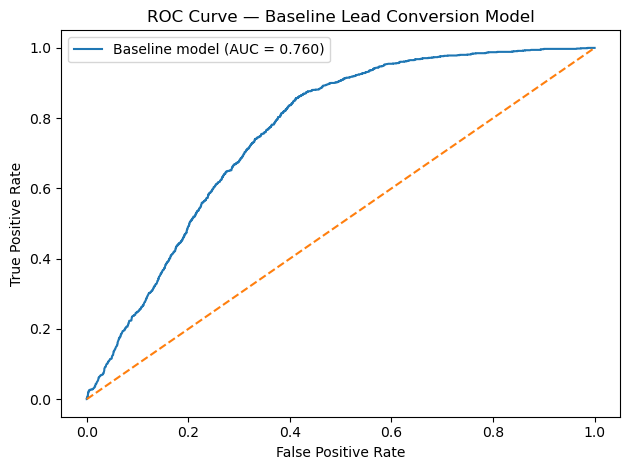

In [33]:
# Cell 16 — Baseline model performance: ROC curve
# Purpose:
# - Visualise the baseline model’s ability to discriminate between converted
#   and non-converted leads.
# - Provide a threshold-independent performance summary that complements
#   the ROC-AUC statistic.

import matplotlib.pyplot as plt          # Provides plotting functionality for visual outputs
from sklearn.metrics import roc_curve    # Generates ROC curve coordinates across thresholds

# Compute ROC curve coordinates using predicted probabilities from the held-out test set
fpr, tpr, _ = roc_curve(
    y_test,                              # True outcomes for the test set
    y_prob                               # Predicted conversion probabilities from the baseline model
)

# Recompute ROC-AUC for consistency with the plotted curve
auc_baseline = roc_auc_score(
    y_test,
    y_prob
)

# Plot the ROC curve for the baseline model
plt.figure()
plt.plot(
    fpr,                                 # False positive rate values
    tpr,                                 # True positive rate values
    label=f"Baseline model (AUC = {auc_baseline:.3f})"
)

# Add a reference line representing random classification performance
plt.plot(
    [0, 1],
    [0, 1],
    linestyle="--"
)

# Add axis labels and title
plt.xlabel("False Positive Rate")        # 1 − specificity
plt.ylabel("True Positive Rate")         # sensitivity / recall
plt.title("ROC Curve — Baseline Lead Conversion Model")
plt.legend()

# Save the figure for downstream use
roc_path = os.path.join(output_dir, "roc_baseline_model.png")
plt.tight_layout()
plt.savefig(roc_path, dpi=200, bbox_inches="tight")
print("ROC curve saved to:", roc_path)

# Display the plot in the notebook
plt.show()

## Cell 17 — Model comparison: AUC summary table

In [35]:
# Purpose:
# - Summarise predictive performance across all fitted models.
# - Enable direct comparison of baseline and interaction specifications.
# - Provide a compact, reusable table for downstream visualisation.

# Assemble AUC results from previously fitted models
auc_summary = pd.DataFrame({
    "model": [
        "Baseline",
        "Agent × Lead Source",
        "Agent × State"
    ],
    "roc_auc": [
        auc_baseline,    # Baseline logistic regression
        auc_int,         # Agent × lead source interaction model
        auc_state        # Agent × state interaction model
    ]
})

# Sort models by predictive performance (highest AUC first)
auc_summary = auc_summary.sort_values(
    "roc_auc",
    ascending=False
).reset_index(drop=True)

# Display the comparison table
print(auc_summary)

# Save the table for reuse in reporting and appendix material
auc_table_path = os.path.join(output_dir, "auc_model_comparison.csv")
auc_summary.to_csv(auc_table_path, index=False)
print("AUC summary table saved to:", auc_table_path)


                 model   roc_auc
0             Baseline  0.760103
1  Agent × Lead Source  0.741935
2        Agent × State  0.677003
AUC summary table saved to: outputs_01_core/auc_model_comparison.csv


## Cell 18 — Model comparison visual: AUC bar chart

AUC bar chart saved to: outputs_01_core/auc_model_comparison_bar.png


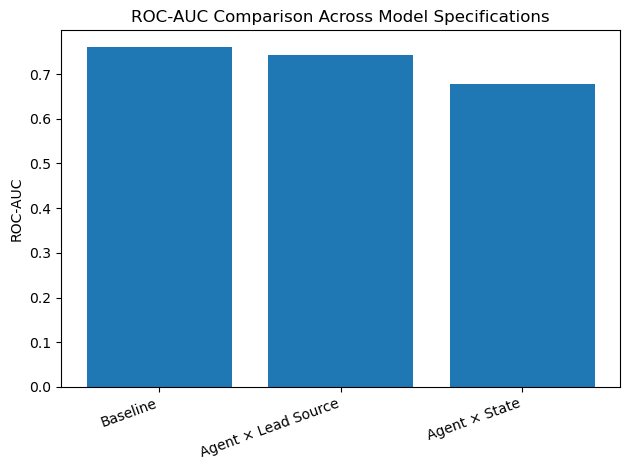

In [37]:
# Purpose:
# - Visualise predictive performance differences across the fitted models.
# - Provide a simple, readable comparison that complements the AUC summary table.

# Create a bar chart of ROC-AUC by model
plt.figure()
plt.bar(
    auc_summary["model"],          # Model labels (baseline and interaction specifications)
    auc_summary["roc_auc"]         # Corresponding ROC-AUC values
)

# Add axis labels and title for interpretability
plt.ylabel("ROC-AUC")              # y-axis: discrimination performance
plt.title("ROC-AUC Comparison Across Model Specifications")
plt.xticks(rotation=20, ha="right")  # Improve readability of longer model names

# Save the figure for reuse in reporting
auc_plot_path = os.path.join(output_dir, "auc_model_comparison_bar.png")
plt.tight_layout()
plt.savefig(auc_plot_path, dpi=200, bbox_inches="tight")
print("AUC bar chart saved to:", auc_plot_path)

# Display the plot in the notebook
plt.show()

## Cell 19 — Conversion heterogeneity by lead source (top sources by volume with overall benchmark)

               lead_source  leads  conversion_rate  conversion_rate_pct
0    oursmartquotes.com.au  88016         0.037539             3.753863
1                  Tedirex  31869         0.002855             0.285544
2           Google Adwords  15084         0.029833             2.983294
3           Data4U October  10050         0.000299             0.029851
4                  organic   4093         0.021256             2.125580
5   Right Health Insurance   3303         0.025431             2.543143
6        Energy Deal Sales   1904         0.008929             0.892857
7          CHOOSE N SWITCH   1301         0.086088             8.608762
8         SEO_HOMEPAGE_NEW    772         0.053109             5.310881
9   comparingexpert.com.au    618         0.008091             0.809061
10  ED Consent leads to HD    449         0.004454             0.445434
11             hd_web_lead    425         0.018824             1.882353

Overall conversion rate: 2.66%
Lead source summary table saved 

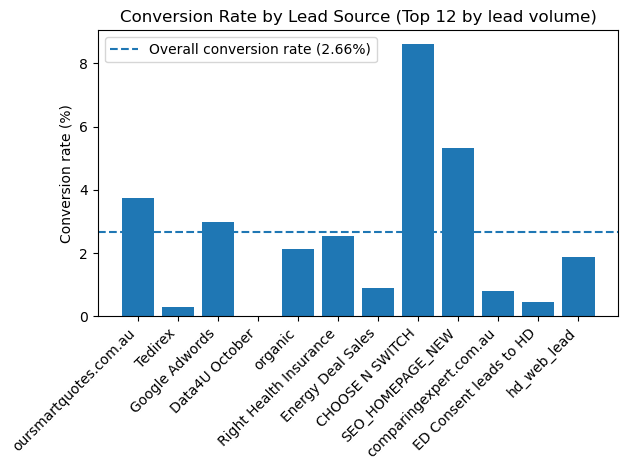

In [39]:
# Purpose:
# - Quantify variation in conversion rates across lead sources.
# - Demonstrate that uniform treatment of leads is inefficient.
# - Anchor source-level performance against the overall conversion benchmark.

# Number of lead sources to display (ranked by lead volume)
top_n_sources = 12  # Focus on the main operational drivers while keeping the chart readable

# Compute lead volume and conversion rate by lead source
source_summary = (
    lead_model
    .groupby("lead_source", dropna=False)                     # Group leads by originating source
    .agg(
        leads=("lead_id", "count"),                           # Total number of leads per source
        conversion_rate=("sale_flag", "mean")                 # Mean of sale_flag equals conversion rate
    )
    .sort_values("leads", ascending=False)                    # Rank by operational importance (volume)
    .head(top_n_sources)                                      # Retain only top sources by volume
    .reset_index()
)

# Express conversion rates as percentages for interpretability
source_summary["conversion_rate_pct"] = source_summary["conversion_rate"] * 100

# Calculate overall conversion rate as a benchmark
overall_conversion_pct = lead_model["sale_flag"].mean() * 100

# Display the summary table
print(source_summary)
print(f"\nOverall conversion rate: {overall_conversion_pct:.2f}%")

# Save the table for reuse
source_table_path = os.path.join(
    output_dir,
    "conversion_by_lead_source_top_volume.csv"
)
source_summary.to_csv(source_table_path, index=False)
print("Lead source summary table saved to:", source_table_path)

# Plot conversion rate by lead source with overall benchmark
plt.figure()
plt.bar(
    source_summary["lead_source"].astype(str),                # Lead source labels
    source_summary["conversion_rate_pct"]                     # Conversion rate (%)
)

# Add horizontal reference line for overall conversion rate
plt.axhline(
    y=overall_conversion_pct,                                 # Overall benchmark level
    linestyle="--",
    label=f"Overall conversion rate ({overall_conversion_pct:.2f}%)"
)

# Add labels and title
plt.ylabel("Conversion rate (%)")
plt.title(
    f"Conversion Rate by Lead Source (Top {top_n_sources} by lead volume)"
)
plt.xticks(rotation=45, ha="right")
plt.legend()

# Save the figure for reuse
source_plot_path = os.path.join(
    output_dir,
    "conversion_by_lead_source_top_volume_with_benchmark.png"
)
plt.tight_layout()
plt.savefig(source_plot_path, dpi=200, bbox_inches="tight")
print("Lead source conversion chart saved to:", source_plot_path)

# Display the plot in the notebook
plt.show()


## Cell 20 — Conversion heterogeneity by agent (minimum lead-volume threshold)

In [41]:
# Purpose:
# - Summarise variation in conversion rates across agents.
# - Apply a minimum lead-volume threshold to ensure stable, interpretable comparisons.
# - Provide descriptive context before examining conditional agent suitability.

# Define minimum number of leads required for an agent to be included
min_leads_per_agent = 200  # Aligns with thresholds used in interaction modelling

# Compute lead volume and conversion rate by agent
agent_summary = (
    lead_model
    .groupby("user", dropna=False)                           # Group leads by agent ID
    .agg(
        leads=("lead_id", "count"),                          # Total leads handled by the agent
        conversion_rate=("sale_flag", "mean")                # Mean of sale_flag equals conversion rate
    )
    .reset_index()
)

# Retain only agents meeting the minimum lead-volume requirement
agent_summary = agent_summary[
    agent_summary["leads"] >= min_leads_per_agent
].copy()

# Express conversion rates as percentages for interpretability
agent_summary["conversion_rate_pct"] = agent_summary["conversion_rate"] * 100

# Sort agents by conversion rate (highest to lowest)
agent_summary = agent_summary.sort_values(
    "conversion_rate",
    ascending=False
).reset_index(drop=True)

# Display a snapshot of agent-level variation
print("Top 10 agents by conversion rate (min 200 leads):")
print(agent_summary.head(10))

print("\nBottom 10 agents by conversion rate (min 200 leads):")
print(agent_summary.tail(10))

# Save the full agent-level summary for reference
agent_table_path = os.path.join(
    output_dir,
    "conversion_by_agent_min_200_leads.csv"
)
agent_summary.to_csv(agent_table_path, index=False)
print("\nAgent conversion summary table saved to:", agent_table_path)


Top 10 agents by conversion rate (min 200 leads):
      user  leads  conversion_rate  conversion_rate_pct
0  12730.0    251         0.163347            16.334661
1  11964.0   2475         0.067071             6.707071
2  11264.0   4299         0.063503             6.350314
3  11741.0   3973         0.057891             5.789076
4  13677.0   2827         0.056951             5.695083
5  13843.0   4117         0.051008             5.100802
6  13652.0   5253         0.050447             5.044736
7  13621.0   6116         0.048725             4.872466
8  12829.0   3510         0.045299             4.529915
9  13444.0   8192         0.043091             4.309082

Bottom 10 agents by conversion rate (min 200 leads):
       user  leads  conversion_rate  conversion_rate_pct
34  14191.0    858         0.005828             0.582751
35  14021.0   3107         0.004828             0.482781
36  14198.0   1066         0.003752             0.375235
37  14196.0    879         0.003413             0.34

## Cell 21 — Routing table: top agents by lead source (interaction model)

In [43]:
# Purpose:
# - Translate agent × lead source interaction effects into a practical routing table.
# - Identify which agents are most suitable for each major lead source.
# - Retain only agents with sufficient exposure to ensure stable recommendations.

# Reuse minimum volume threshold applied elsewhere in the notebook
min_leads_per_agent = 200

# Compute agent lead volumes (cast agent IDs to string for consistency)
agent_volumes = (
    lead_model
    .assign(user=lambda d: d["user"].astype(str))          # Ensure agent ID is string
    .groupby("user", dropna=False)
    .agg(leads=("lead_id", "count"))
    .reset_index()
)

# Prepare interaction coefficient table from the fitted interaction model
interaction_terms = coef_int.copy()                        # coef_int created in Cell 13
interaction_terms = interaction_terms[
    interaction_terms["feature"].str.startswith("agent_source_")
].copy()

# Recover agent ID and lead source from interaction term names
interaction_terms["agent_source"] = (
    interaction_terms["feature"]
    .str.replace("agent_source_", "", regex=False)
)

split = interaction_terms["agent_source"].str.split(" \\| ", expand=True)
interaction_terms["user"] = split[0].astype(str)           # Agent ID as string
interaction_terms["lead_source"] = split[1]

# Attach agent lead volumes
interaction_terms = interaction_terms.merge(
    agent_volumes,
    how="left",
    on="user"
)

# Retain only agents meeting the minimum lead-volume threshold
interaction_terms = interaction_terms[
    interaction_terms["leads"] >= min_leads_per_agent
].copy()

# For each lead source, select the top agents by interaction coefficient
top_agents_by_source = (
    interaction_terms
    .sort_values(
        ["lead_source", "coefficient"],
        ascending=[True, False]
    )
    .groupby("lead_source", as_index=False)
    .head(3)                                                # Top 3 agents per lead source
    [["lead_source", "user", "leads", "coefficient"]]
)

# Display the routing-style table
print("Top agents by lead source (interaction model):")
print(top_agents_by_source)

# Save routing table for reuse
routing_table_path = os.path.join(
    output_dir,
    "routing_top_agents_by_lead_source.csv"
)
top_agents_by_source.to_csv(routing_table_path, index=False)
print("\nRouting table saved to:", routing_table_path)


Top agents by lead source (interaction model):
                lead_source     user  leads  coefficient
98          CHOOSE N SWITCH  13416.0   3958     2.302307
225         CHOOSE N SWITCH  14017.0   9623     1.869856
116         CHOOSE N SWITCH  13505.0   3990     1.568826
255          Data4U October  14021.0   3107     1.915792
183          Data4U October  13828.0    209    -0.002270
199          Data4U October  13843.0   4117    -0.005479
236       Energy Deal Sales  14018.0   2836     3.986071
34        Energy Deal Sales  12413.0   1807     2.299039
99        Energy Deal Sales  13416.0   3958     2.148476
191          Google Adwords  13842.0   3916     1.332677
1            Google Adwords  11264.0   4299     1.269255
51           Google Adwords  12829.0   3510     1.249409
82   Right Health Insurance  13276.0   7040     2.268201
229  Right Health Insurance  14017.0   9623     1.934860
2    Right Health Insurance  11264.0   4299     1.623858
203        SEO_HOMEPAGE_NEW  13843.0   41

## Cell 22 — Routing table with lead source context (volume and conversion)

In [45]:
# Purpose:
# - Attach lead source volume and baseline conversion rate to the routing table.
# - Provide operational context so routing recommendations are not presented in isolation.
# - Sort lead sources by lead volume to reflect practical impact.

# Compute lead source volume and baseline conversion rate from the full lead-level table
source_context = (
    lead_model
    .groupby("lead_source", dropna=False)
    .agg(
        source_leads=("lead_id", "count"),                 # Total leads generated by the source
        source_conversion_rate=("sale_flag", "mean")       # Baseline conversion rate for the source
    )
    .reset_index()
)

# Express source conversion rate as a percentage for readability
source_context["source_conversion_rate_pct"] = source_context["source_conversion_rate"] * 100

# Attach source context to the routing table (top agents per source)
routing_with_context = top_agents_by_source.merge(
    source_context,
    how="left",
    on="lead_source"
)

# Sort lead sources by operational importance (highest volume first), then by coefficient
routing_with_context = routing_with_context.sort_values(
    ["source_leads", "lead_source", "coefficient"],
    ascending=[False, True, False]
).reset_index(drop=True)

# Display the enriched routing table
print("Routing table with lead source context:")
print(routing_with_context)

# Save enriched routing table for reuse
routing_context_path = os.path.join(
    output_dir,
    "routing_top_agents_by_lead_source_with_context.csv"
)
routing_with_context.to_csv(routing_context_path, index=False)
print("\nRouting table with context saved to:", routing_context_path)


Routing table with lead source context:
               lead_source     user  leads  coefficient  source_leads  source_conversion_rate  source_conversion_rate_pct
0    oursmartquotes.com.au  13828.0    209     1.816463         88016                0.037539                    3.753863
1    oursmartquotes.com.au  14189.0   1067     1.783078         88016                0.037539                    3.753863
2    oursmartquotes.com.au  14190.0   1015     1.741297         88016                0.037539                    3.753863
3                  Tedirex  14197.0   1043     2.286296         31869                0.002855                    0.285544
4                  Tedirex  14128.0   7926     1.819841         31869                0.002855                    0.285544
5                  Tedirex  14196.0    879     1.699840         31869                0.002855                    0.285544
6           Google Adwords  13842.0   3916     1.332677         15084                0.029833             

In [46]:
# Save the final lead-level modelling table for reuse in descriptive analysis
lead_model.to_csv("lead_model_final.csv", index=False)
print("lead_model saved to lead_model_final.csv")


lead_model saved to lead_model_final.csv
